In [1]:
import os
import sys

# Get the current working directory and add the parent directory to the Python path
current_working_directory = os.getcwd()
print(os.path.join(current_working_directory, ".."))
sys.path.append(os.path.join(current_working_directory, ".."))

/Users/L024258/lilly_work/github-copilot/exploration/langgraph/..


In [2]:
import pprint

### Defining the Graph state

State is the object that is passed between nodes in the graph.

In [3]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, AnyMessage
import operator
from IPython.display import Image, display

In [4]:
class AgentState(TypedDict):
    input: str
    agent_outcome: List[AnyMessage]
    chat_history: Annotated[list, operator.add]

### Defining the LLM

In [5]:
from models.llm import LLM

model = LLM('gpt-4o-mini')
llm = model.load_model()

### Define the agent (node)

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def research_agent(data):
    print(data)
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant"
                "\nUser Query: {input}"
            ),
            MessagesPlaceholder(variable_name="chat_history"),
        ]
    )
    agent = prompt | llm
    result = agent.invoke(data)
    return {
                'agent_outcome': [result],
                'chat_history': ["User: " + data['input'] + "\n AI Message: " + result.content],
            }

### Defining the workflow

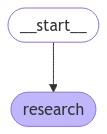

In [7]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(AgentState)

workflow.add_node("research", research_agent)
workflow.set_entry_point("research")

app = workflow.compile()
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
inputs = {
    "input": "What are the recent papers on Small Language Models?",
}

`invoke()` method is used to run the workflow. It runs the entire graph (workflow) synchronously. 

It takes the input data and returns the final state of the workflow. 

The final state contains the output of the last agent that was executed in the workflow.

In [9]:
app.invoke(input=inputs)

{'input': 'What are the recent papers on Small Language Models?', 'chat_history': []}


{'input': 'What are the recent papers on Small Language Models?',
 'agent_outcome': [AIMessage(content='As of my last update in October 2023, I can\'t access real-time databases or the internet to provide the most recent papers. However, I can suggest some strategies for finding recent papers on small language models:\n\n1. **arXiv.org**: This is a repository for research papers in various fields, including computer science and artificial intelligence. You can search for "small language models" or related keywords to find the latest papers.\n\n2. **Google Scholar**: Use Google Scholar to search for recent publications. You can set the search filter to show only papers published in the last year or so.\n\n3. **Conference Proceedings**: Check the proceedings of major AI and NLP conferences such as ACL, EMNLP, NeurIPS, and ICML. They often feature cutting-edge research on language models.\n\n4. **Research Journals**: Look into journals like the Journal of Machine Learning Research (JMLR) 

In [ ]:
for s in app.stream(input=inputs):
    pprint.pp(s)
    print(list(s.values())[0]['agent_outcome'][0].content)
    print("-----"*20)

In [ ]:
def stream_app_updates(user_input: str, chat_history: list):
    inputs = {
        "input": user_input,
        "chat_history": chat_history
    }
    for event in app.stream(input=inputs):
        for value in event.values():
            response = value["agent_outcome"][-1].content
            conv = value["chat_history"][-1]
    return response, conv

chat_history = []
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        response, conv = stream_app_updates(user_input, chat_history)
    except:
        # fallback if input() is not available
        print("User: " + user_input)
        response, conv = stream_app_updates(user_input, chat_history)
        break
    print("Assistant:", response)
    chat_history.append(conv)